In [1]:
#Notebook to visualize output from neural network training and validation
#To run: 1) on remote - jupyter notebook --no-browser --port=8340
#2) on local - ssh -N -f -L localhost:8888:localhost:8340 alpv95@sh-ln07.stanford.edu (have to change sherlock node accordingly)
# can check port activity with sudo lsof -i:8888, should stay open once (2) has been run once
#kill all processes on port using kill $(lsof -t -i :8888)

#Would like to be able to load a trained net and run predictions on a small dataset (a few tracks) in this notebook 
#Also want to visulaize training error/validation error in plot here as net trains
#want train_loss + train_Acc + val_acc (for regression, depending on loss function, train_acc may be well represented by train_loss)


%matplotlib inline
import sys
import os
sys.path.insert(0, '/home/groups/kipac/alpv95/tracksml')
import matplotlib.pyplot as plt
import h5py
import numpy as np
import shutil
import itertools
import copy
import torch
import pickle
import hexagdly
from util import loss
from util.pydataloader import H5Dataset, ToTensor, ZNormalize
from collections import namedtuple
from nn.cnn import TrackAngleRegressor
from formats.dense_square import DenseSquareSimTracks
from formats.sparse_hex import SparseHexTracks, SparseHexSimTracks
from ellipse.ellipse_methods import calc_angle
from torchvision import transforms
from polarization.polarization import fit_polarization_angle, fit_modulation_factor_params, modulation_factor

home_dir = '/home/groups/kipac/alpv95/tracksml/'

def read_from_pickle(path):
    with open(path, 'rb') as file:
        try:
            while True:
                yield pickle.load(file) #yield gives a generator (effectively a list that only knows one element at a time)
                #containing the objects saved in the pickle 
        except EOFError:
            pass

#hd5py files are split into groups (->python dicts) and datasets (->python numpy arrays)
#usually will have format: e.g. dict(dict(numpyarray))
#i.e. f = h5py.File(filename, 'r'), f['key']['key2'][numpyarray index]
#get group keys using f.keys()
#if dataset has only a scalar value and not an array, access that single scalar element using [()] (this command shows whole array normally)

def read_hdf5(path):
    #filename = home_dir + 'data/nn/set2_combined_test_1/results/net3_0.h5'
    data_group = h5py.File(path, 'r')
    return data_group['root']

############## hd5py file to python dictionary
def recursively_load_dict_contents_from_group(h5file, path='root/'):
    """
    Load contents of an HDF5 group. If further groups are encountered,
    treat them like dicts and continue to load them recursively.
    """
    
    ans = {}
    for key, item in h5file[path].items():
        if type(item) is h5py._hl.dataset.Dataset:
            ans[key] = item[()]
        elif type(item) is h5py._hl.group.Group:
            ans[key] = recursively_load_dict_contents_from_group(h5file, path + key + '/')
    return ans

def plot_angle_preds(angles, phi0, C1, C2, mu, name=''):
    """Plot distribution of predicted track angles + overall predicted polarization angle + stats"""
    if name != '':
        name = name + ' '

    bins = np.linspace(-np.pi, np.pi, 40)

    x = np.linspace(-np.pi, np.pi, 199)
    N = C1 + C2 * np.square(np.cos(x - phi0))

    plt.figure()
    plt.hist(angles, bins=bins, density=True)
    plt.plot(x, N, linewidth=4, label='$C_1 + C_2\cos^2(\phi-\phi_0)$')
    plt.xlabel('$\phi$ (rad)')
    plt.ylabel('Prob')
    plt.legend()
    plt.title('{}Modulation Factor Params Fit\n$\phi_0$ = {:.3f}; $C_1$ = {:.3f}, $C_2$ = {:.3f}; $\mu$ = {:.3f}'.format(name, phi0, C1, C2, mu))
    
def plot_angle_preds_only(angles, name=''):
    """Plot just the hist of angles"""
    if name != '':
        name = name + ' '

    plt.figure()
    bins = np.linspace(-np.pi, np.pi, 40)
    plt.hist(angles, bins=bins, density=True)
    plt.xlabel('$\phi$ (rad)')
    plt.ylabel('Prob')
    plt.title('{}Distribution of predicted angles'.format(name))

/home/groups/kipac/alpv95/tracksml/nn/cnn.py:8: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/share/software/user/open/python/3.6.1/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/share/software/user/open/python/3.6.1/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/users/alpv95/.local/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/users/alpv95/.local/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/users/alpv95/.local/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 50

In [2]:
#example for how to use pickle reading
p = read_from_pickle(home_dir + 'data/nn/set2_combined_test_1/working/output5')
for element in p:
    print(element)

FileNotFoundError: [Errno 2] No such file or directory: '/home/groups/kipac/alpv95/tracksml/data/nn/set2_combined_test_1/working/output5'

In [2]:
network = "resnet_cos6-7"

## Visualize Training and Validation Results

In [13]:
#Load desired net results
results = read_hdf5(home_dir + 'data/nn/' + network + '/results/net1_0.h5')
train_loss = np.array([results['train']['stats']['loss'][i] for i in range(len(results['train']['stats']['loss']))])
val_loss = np.array([results['train']['stats']['val_loss'][i] for i in range(len(results['train']['stats']['val_loss']))])
steps = results['train']['stats']['step'] #1step is 1 batch minibatch
val_steps = results['train']['stats']['val_step']

In [6]:
val_loss[()]

array([0.37083401, 0.35335942, 0.34078645, 0.35138915, 0.35736001,
       0.36456902, 0.33549584, 0.3642466 , 0.3404588 , 0.33009474,
       0.32918248, 0.32763583, 0.33254123, 0.32973836, 0.32637986,
       0.32816108, 0.34150364, 0.33370711, 0.33130162, 0.32652153,
       0.32724171, 0.33124562, 0.32319019, 0.32333139, 0.32418666,
       0.32302535, 0.32317652, 0.32313036, 0.32268786, 0.32285767,
       0.3232678 , 0.32301792, 0.32259662, 0.32263106, 0.32262336,
       0.32257656, 0.32269245, 0.32278204, 0.3227967 , 0.32280483,
       0.32277428, 0.32282611, 0.32262053, 0.32289945, 0.32269925,
       0.32283142, 0.32260662, 0.32262263, 0.32300692, 0.32287689])

In [10]:
data_file2 = home_dir + 'data/expanded/gen2a_aug/' + 'set1_6p4_meas_dense_square_tracks_0pol_76789trans.h5'
with h5py.File(data_file2, 'r') as f:
     rotations = f['train']['rotations'][()]
        
data_file1 = home_dir + 'data/expanded/gen2a_aug/' + 'set1_6p4_meas_dense_square_tracks_1pol_76789trans.h5'
with h5py.File(data_file1, 'r') as f:
     rotations1 = f['train']['rotations'][()]
        
data_file = home_dir +'data/expanded/gen2a_aug/gen2a_combined_aug6-7.h5'
with h5py.File(data_file, 'r') as f:
     rotations_sim = f['test']['rotations'][()]

In [11]:
rotations_sim.shape

(52979, 2)

In [ ]:
data_file2 = home_dir + 'data/expanded/gen2a_aug/' + 'set1_6p4_meas_dense_square_tracks_0pol_76789trans.h5'
with h5py.File(data_file2, 'r') as f:
     cube = f['train']['tracks_cube'][()]
        
data_file = home_dir +'data/expanded/gen2a_aug/gen2a_combined_aug6-7.h5'
with h5py.File(data_file, 'r') as f:
     cube_sim = f['train']['tracks_cube'][()]

In [12]:
data_hex =  home_dir +'data/expanded/gen2a_aug/' + 'set1_6p4_meas_sparse_hex_tracks_1pol_76789trans.h5'
with h5py.File(data_hex, 'r') as f:
    hexo = SparseHexTracks.load(f=f['test'])

Val Acc:  1.0161904427640487
Test Acc:  1.0219163540463532


(array([ 969.,  979., 1045., 1148., 1257., 1351., 1447., 1535., 1620.,
        1879., 1957., 1877., 1962., 2076., 2234., 2195., 2103., 1928.,
        1814., 1642., 1472., 1397., 1248., 1056.,  989.,  945.,  951.,
         991., 1070., 1226., 1283., 1305., 1455., 1602., 1707., 1810.,
        1886., 1935., 2034., 2119., 2100., 2032., 1928., 1708., 1585.,
        1424., 1286., 1157., 1129.,  941.]),
 array([-3.14142823e+00, -3.01576810e+00, -2.89010797e+00, -2.76444783e+00,
        -2.63878770e+00, -2.51312757e+00, -2.38746743e+00, -2.26180730e+00,
        -2.13614717e+00, -2.01048703e+00, -1.88482690e+00, -1.75916677e+00,
        -1.63350663e+00, -1.50784650e+00, -1.38218637e+00, -1.25652623e+00,
        -1.13086610e+00, -1.00520597e+00, -8.79545832e-01, -7.53885698e-01,
        -6.28225565e-01, -5.02565432e-01, -3.76905298e-01, -2.51245165e-01,
        -1.25585032e-01,  7.51018524e-05,  1.25735235e-01,  2.51395369e-01,
         3.77055502e-01,  5.02715635e-01,  6.28375769e-01,  7.540359

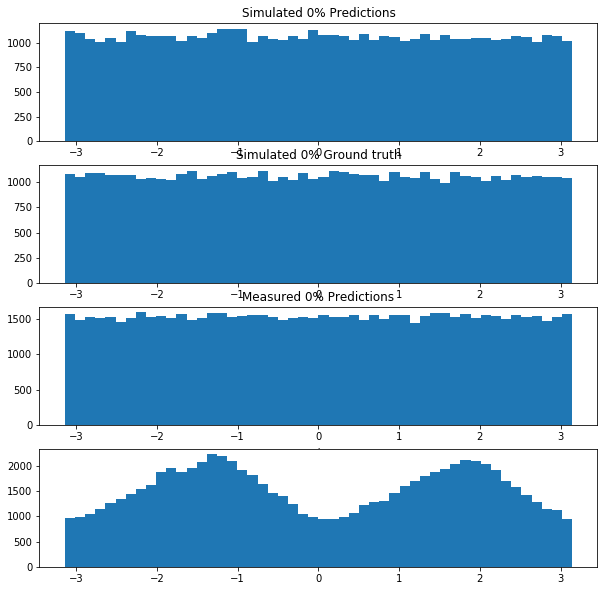

In [14]:
data_file2 = home_dir + 'data/expanded/gen2a_aug/' + 'set1_6p4_meas_dense_square_tracks_0pol_76789trans.h5'
data_file = home_dir +'data/expanded/gen2a_aug/gen2a_combined_aug6-7.h5'
data_hex = home_dir + 'data/expanded/gen2a_aug/' + 'set1_6p4_meas_sparse_hex_tracks_0pol_76789trans.h5'
print('Val Acc: ', results['validate']['mse'][()])
print('Test Acc: ',results['test']['mse'][()])

plt.figure(figsize=(10,10))
plt.subplot(411)
#-(results['test']['metrics']['y_hat_angles'][()] + rotations_sim[:,1]) - rotations_sim[:,0]
sim_final = np.zeros_like(results['test']['metrics']['y_hat_angles'][()])
for i,me in enumerate(-(results['test']['metrics']['y_hat_angles'][()] + rotations_sim[:,1]*np.pi/2) - rotations_sim[:,0]):
    if 3*np.pi > me > np.pi:
        sim_final[i] = me - 2*np.pi
    elif 5*np.pi > me > 3*np.pi:
        sim_final[i] = me - 4*np.pi
    elif -3*np.pi < me < -np.pi:
        sim_final[i] = me + 2*np.pi
    elif -5*np.pi < me < -3*np.pi:
        sim_final[i] = me + 4*np.pi
    else:
        sim_final[i] = me
plt.hist(sim_final,50)
plt.title('Simulated 0% Predictions')

with h5py.File(data_file, 'r') as f:
    test_angles = f['test']['angles'][()]
#test_angles = [test_angle + 2*np.pi if test_angle < -np.pi else test_angle for test_angle in test_angles]
    
sim_real = np.zeros_like(test_angles)
for i,me in enumerate(-(test_angles + rotations_sim[:,1]*np.pi/2) - rotations_sim[:,0]):
    if 3*np.pi > me > np.pi:
        sim_real[i] = me - 2*np.pi
    elif 5*np.pi > me > 3*np.pi:
        sim_real[i] = me - 4*np.pi
    elif -3*np.pi < me < -np.pi:
        sim_real[i] = me + 2*np.pi
    elif -5*np.pi < me < -3*np.pi:
        sim_real[i] = me + 4*np.pi
    else:
        sim_real[i] = me
plt.subplot(412)
plt.hist(sim_real, 50)
plt.title('Simulated 0% Ground truth')

plt.subplot(413)
measured_final = np.zeros_like(results['meas']['metrics'][()])
#-(results['meas']['metrics'][()] + rotations[:,1]) - rotations[:,0]
for i,me in enumerate(-(results['meas']['metrics'][()] + rotations[:,1] * np.pi/2) - rotations[:,0]):
    if 3*np.pi > me > np.pi:
        measured_final[i] = me - 2*np.pi
    elif 5*np.pi > me > 3*np.pi:
        measured_final[i] = me - 4*np.pi
    elif -3*np.pi < me < -np.pi:

        measured_final[i] = me + 2*np.pi
    elif -5*np.pi < me < -3*np.pi:
        measured_final[i] = me + 4*np.pi
    else:
        measured_final[i] = me
#measured_final = np.mod(results['meas']['metrics'][()] - rotations,2*np.pi)
plt.hist(measured_final,50)
plt.xlabel(r'$\phi$')
plt.title('Measured 0% Predictions')

plt.subplot(414)
measured_finaltest = np.zeros_like(results['meas_test']['metrics'][()])
#-(results['meas_test']['metrics'][()] + rotations1[:,1]) - rotations1[:,0]
for i,me in enumerate(-(results['meas_test']['metrics'][()] + rotations1[:,1]* np.pi/2) - rotations1[:,0]):
    if 3*np.pi > me > np.pi:
        measured_finaltest[i] = me - 2*np.pi
    elif 5*np.pi > me > 3*np.pi:
        measured_finaltest[i] = me - 4*np.pi
    elif -3*np.pi < me < -np.pi:
        measured_finaltest[i] = me + 2*np.pi
    elif -5*np.pi < me < -3*np.pi:
        measured_finaltest[i] = me + 4*np.pi
    else:
        measured_finaltest[i] = me
#measured_final = np.mod(results['meas']['metrics'][()] - rotations,2*np.pi)
plt.hist(measured_finaltest,50)


# # ellipse_y_hats = []
# # for i in range(hexo.n_tracks):
# #     theta,_,_ = calc_angle(hexo[i])
# #     ellipse_y_hats.append(theta)
# # ellipse_y_hats = np.array(ellipse_y_hats)
# plt.subplot(515)
# plt.hist(ellipse_y_hats,50)

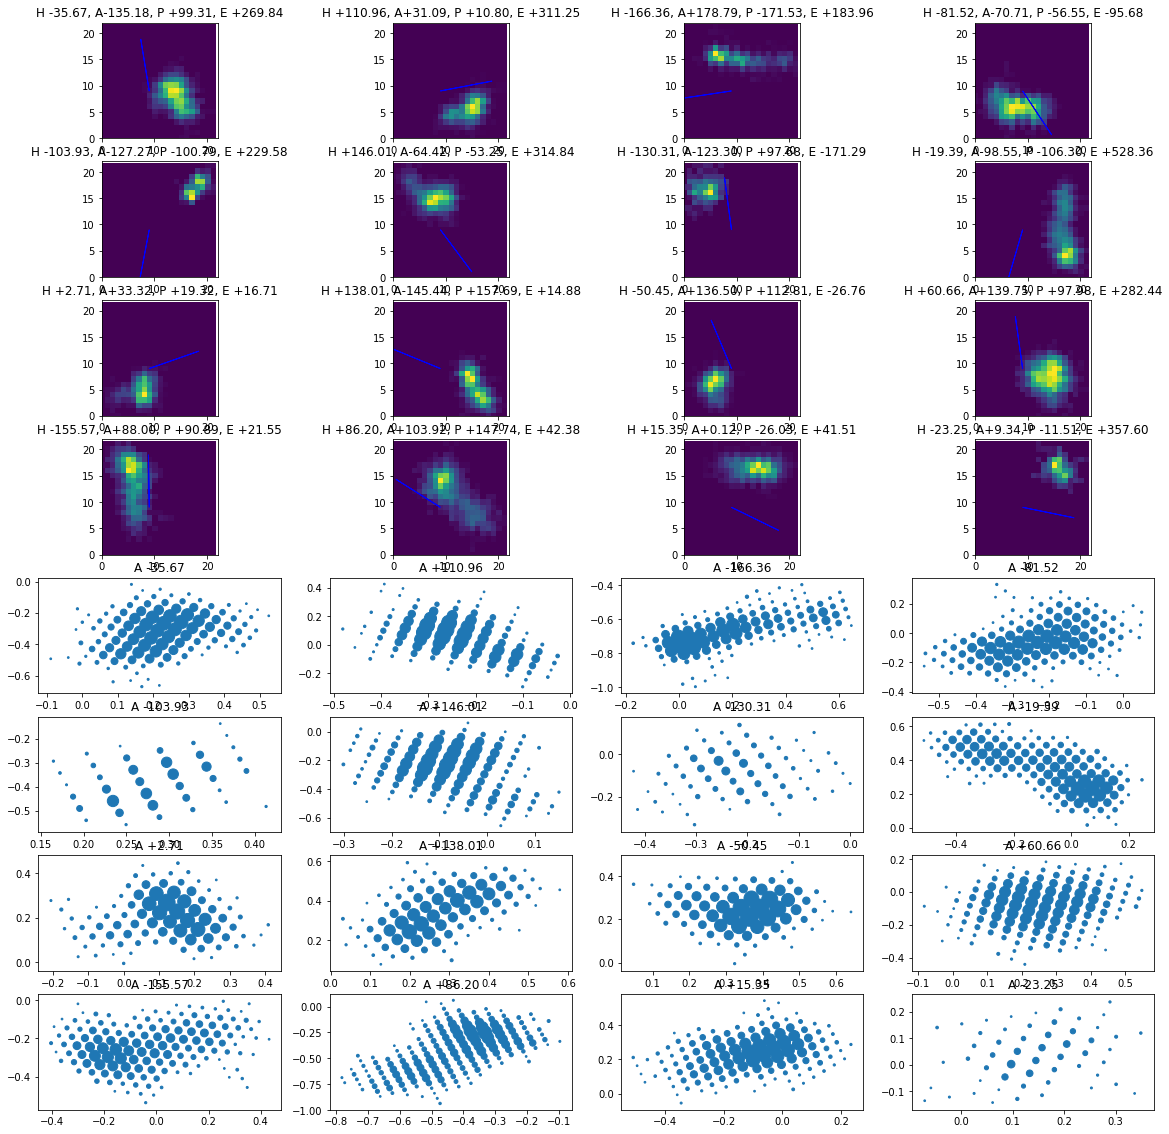

In [37]:
losstype = 'cos'
vlength = 10
plt.figure(figsize=(20,20))
for idx in range(1,33):
        if idx < 17:
            plt.subplot(8,4,idx)
            plt.imshow(cube_sim[idx])     
            #plt.arrow(9,9, vlength * np.cos(cube[idx]), vlength * np.sin(cube[idx]),color='r')
            plt.arrow(9,9, vlength * np.cos(results['test']['metrics']['y_hat_angles'][idx]), vlength * np.sin(results['test']['metrics']['y_hat_angles'][idx]),color='b')
            #plt.arrow(9,9, vlength * np.cos(ellipse_y_hats[batch_idx*batch_size+idx]), vlength * np.sin(ellipse_y_hats[batch_idx*batch_size+idx]),color='g')
                
            plt.xlim(0,22)
            plt.ylim(0,22)
                
            plt.title("H {:+.2f}, A{:+.2f}, P {:+.2f}, E {:+.2f}".format(180 * hexo.angles[idx] / np.pi,  180 * np.array(test_angles[idx]) / np.pi, 180 * results['test']['metrics']['y_hat_angles'][idx] / np.pi ,180 * (-results['test']['metrics']['y_hat_angles'][()]-rotations_sim)[idx] / np.pi))
            
        else:
            plt.subplot(8,4,idx)
            plt.scatter(hexo.x[idx-16],hexo.y[idx-16],hexo.Q[idx-16])
            plt.title("A {:+.2f}".format(180 * hexo.angles[idx-16] / np.pi))
        

Val Acc:  1.0161904427640487
Test Acc:  1.0219163540463532


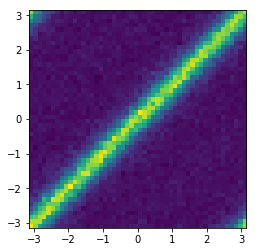

In [16]:
data_file = home_dir +'data/expanded/gen2a_aug/gen2a_combined_aug6-7.h5'
print('Val Acc: ', results['validate']['mse'][()])
print('Test Acc: ',results['test']['mse'][()])
# plt.figure((10,5))
# plt.subplot(311)
# plt.hist(results['test']['metrics']['y_hat_angles'][()],50)

with h5py.File(data_file, 'r') as f:
    test_angles = f['test']['angles'][()]
# plt.subplot(312)
test_angles = [test_angle + 2*np.pi if test_angle < -np.pi else test_angle for test_angle in test_angles]
# plt.hist(test_angles, 50)

# plt.subplot(313)
heatmap, xedges, yedges = np.histogram2d(sim_real, sim_final, bins=50)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.clf()
plt.imshow(heatmap.T, extent=extent, origin='lower')
plt.show()

Val Acc:  1.0161904427640487
Test Acc:  1.0219163540463532


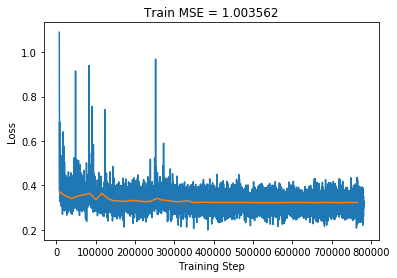

In [17]:
train_mse = results['train']['mse'][()]
print('Val Acc: ', results['validate']['mse'][()])
print('Test Acc: ',results['test']['mse'][()])

plt.plot(steps,train_loss)
plt.plot(val_steps,val_loss)
plt.xlabel('Training Step')
plt.ylabel('Loss')
plt.title('Train MSE = %lf' % train_mse)
plt.show()

## Visualize Net performance on individual tracks

In [3]:
data_file = home_dir +'data/expanded/gen2a_aug/gen2a_combined_aug6-7.h5'
#pol1 = home_dir + 'data/expanded/gen2a_aug/set1_6p4_meas_dense_square_tracks_1pol_76789trans.h5'
pol1 = home_dir + 'data/expanded/gen2a_aug/set1_6p4_meas_dense_square_tracks_1pol_76789trans.h5'
with h5py.File(data_file, 'r') as f:
    mean = f['train']['tracks_mean'][()]
    std = f['train']['tracks_std'][()] 
    maxx = f['train']['tracks_max'][()]
        
test = H5Dataset(data_file,'test', losstype='cos',transform=transforms.Compose([ZNormalize(mean=mean,std=std,set_max=maxx), ToTensor()]))
kwargs = {'num_workers': 1, 'pin_memory': True}
test_loader = torch.utils.data.DataLoader(test, batch_size=512, shuffle=False, **kwargs)


In [12]:
net = recursively_load_dict_contents_from_group(h5py.File(home_dir + 'data/nn/' + network + '/models/net1_0.h5', 'r'))#desired net to visualize
net['hparams']['outputtype'] = net['hparams']['outputtype'].decode("utf-8") #strings saved as byte strings originally
net['opts']['losstype'] = net['opts']['losstype'].decode("utf-8")
net['hparams']['pool1pixels'] = int(net['hparams']['pool1pixels']) #MaxPool2D function doesnt like np.int
net['hparams']['pool2pixels'] = int(net['hparams']['pool2pixels'])


OSError: Unable to open file (unable to open file: name = '/home/groups/kipac/alpv95/tracksml/data/nn/resnet_cos6-7/models/net1_0.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [4]:
m = TrackAngleRegressor(load_checkpoint=home_dir + 'data/nn/' + network + '/models/net1_0.pt')
#m = TrackAngleRegressor(model=net)

In [5]:
test_mse, test_metrics = m.test(test_loader, output_all=True)
#y_hat_angles = m.predict(test_loader)

Evaluating on CPU 

1
1


KeyboardInterrupt: 

In [42]:
test_mse

1.644796935910958

(array([1017., 1053., 1133., 1216., 1233., 1303., 1362., 1522., 1613.,
        1699., 1857., 1956., 2122., 2113., 2265., 2455., 2284., 1972.,
        1666., 1492., 1323., 1263., 1052., 1085., 1049., 1028., 1050.,
        1060., 1162., 1193., 1236., 1319., 1376., 1523., 1618., 1766.,
        2018., 1992., 2120., 2248., 2290., 2132., 1845., 1677., 1436.,
        1283., 1179., 1110., 1033.,  990.]),
 array([-3.14119625e+00, -3.01554184e+00, -2.88988744e+00, -2.76423303e+00,
        -2.63857862e+00, -2.51292422e+00, -2.38726981e+00, -2.26161541e+00,
        -2.13596100e+00, -2.01030659e+00, -1.88465219e+00, -1.75899778e+00,
        -1.63334337e+00, -1.50768897e+00, -1.38203456e+00, -1.25638015e+00,
        -1.13072575e+00, -1.00507134e+00, -8.79416933e-01, -7.53762527e-01,
        -6.28108120e-01, -5.02453713e-01, -3.76799307e-01, -2.51144900e-01,
        -1.25490494e-01,  1.63912773e-04,  1.25818319e-01,  2.51472726e-01,
         3.77127132e-01,  5.02781539e-01,  6.28435946e-01,  7.540903

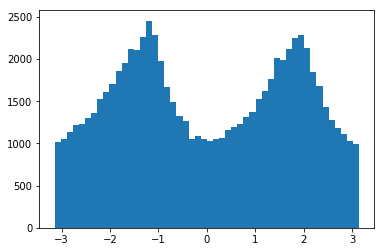

In [37]:
with h5py.File(pol1, 'r') as f:
     rotations = f['validate']['rotations'][()]

sim_final = np.zeros_like(y_hat_angles)
for i,me in enumerate(-(y_hat_angles + rotations[:,1]* np.pi/2) - rotations[:,0]):
    if 3*np.pi > me > np.pi:
        sim_final[i] = me - 2*np.pi
    elif 5*np.pi > me > 3*np.pi:
        sim_final[i] = me - 4*np.pi
    elif -3*np.pi < me < -np.pi:
        sim_final[i] = me + 2*np.pi
    elif -5*np.pi < me < -3*np.pi:
        sim_final[i] = me + 4*np.pi
    else:
        sim_final[i] = me
plt.hist(sim_final,50)

In [29]:
data_file = home_dir +'data/expanded/gen2a_rot/gen2a_combined_rot.h5'
with h5py.File(data_file, 'r') as f:
    train = DenseSquareSimTracks.load(f=f['test'])

(array([1630., 2101., 2884., 4228., 5013., 4970., 3934., 2873., 2078.,
        1211.]),
 array([-7.85339756, -6.75405293, -5.6547083 , -4.55536367, -3.45601903,
        -2.3566744 , -1.25732977, -0.15798514,  0.9413595 ,  2.04070413,
         3.14004876]),
 <a list of 10 Patch objects>)

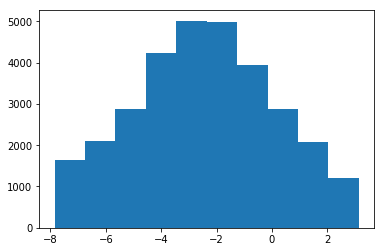

In [31]:
plt.hist(train.angles)

In [9]:
#Use ellipse based methods to calculate angles 
datahex_file = h5py.File(home_dir + 'data/expanded/gen2a_rot/' + 'gen2a_6p0_ang0_sim_sparse_hex_tracks_0pol_15000tot.h5', 'r')
datahex = SparseHexSimTracks.load(f=datahex_file['train'])
print(datahex.n_tracks)

15000


In [10]:
ellipse_y_hats = []
for i in range(datahex.n_tracks):
    theta,_,_ = calc_angle(datahex[i])
    ellipse_y_hats.append(theta)
ellipse_y_hats = np.array(ellipse_y_hats)

In [11]:
# MSE for ellipse method
d = loss.angular_distance(ellipse_y_hats, datahex_file['train']['angles'][()])
ellipse_mse = np.mean(np.square(d))
print(ellipse_mse)

1.344259667261311


Actual, Predicted and Ellipsoidal photoelectron angles displayed on the Square Grid for Simulated Data 6p4:

Total MSE =  3.154333021535926


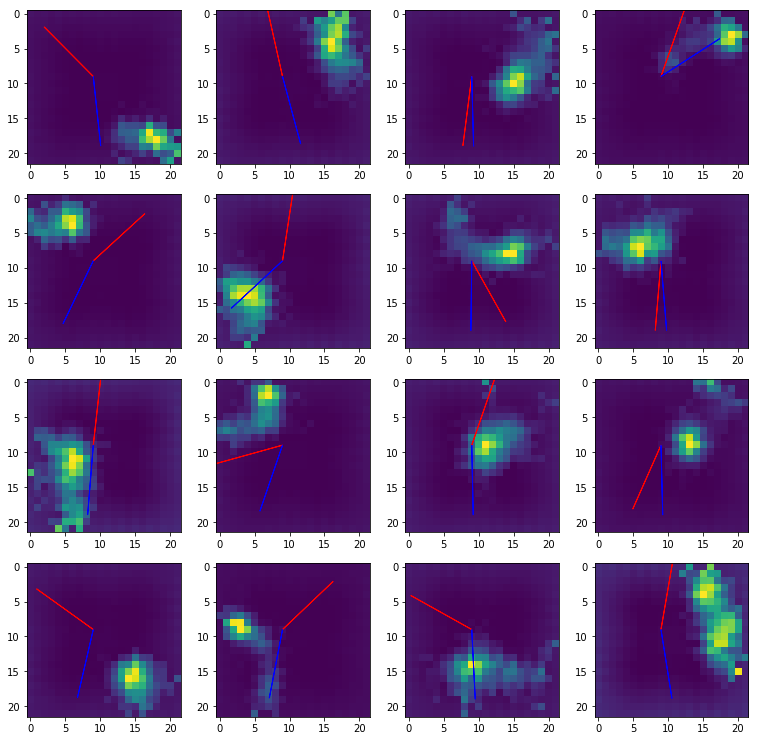

In [10]:
### plot results
#ideally want to also plot absorption points on square grid
batch_size = 64
losstype = 'cos'
vlength = 10
print('Total MSE = ', test_mse)
#print('Ellipsoidal MSE = ', ellipse_mse)

for batch_idx, (X_batch, y_batch) in enumerate(test_loader):
    if (losstype == 'cos'):
        y_batch = np.arctan2(y_batch[:,1], y_batch[:,0])
        
    if batch_idx == 1:
        plt.figure(figsize=(13,13))
        for idx in range(1,17):
            plt.subplot(4,4,idx)
            plt.imshow(X_batch[idx,0])     
            #plt.plot([0,15.5,30],[15.5+15.5*np.tan(y_batch[idx]),15.5,-30*np.tan(y_batch[idx]) + 15.5+15.5*np.tan(y_batch[idx])],'r--')
            #plt.plot([0,15.5,30],[15.5+15.5*np.tan(test_metrics['y_hat_angles'][batch_idx*batch_size+idx]),15.5,-30*np.tan(test_metrics['y_hat_angles'][batch_idx*batch_size+idx]) + 15.5+15.5*np.tan(test_metrics['y_hat_angles'][batch_idx*batch_size+idx])],'b--')
            #plt.plot([0,15.5,30],[15.5+15.5*np.tan(ellipse_y_hats[batch_idx*batch_size+idx]),15.5,-30*np.tan(ellipse_y_hats[batch_idx*batch_size+idx]) + 15.5+15.5*np.tan(ellipse_y_hats[batch_idx*batch_size+idx])],'g--')
            plt.arrow(9,9, vlength * np.cos(y_batch[idx]), vlength * np.sin(y_batch[idx]),color='r')
            plt.arrow(9,9, vlength * np.cos(test_metrics['y_hat_angles'][batch_idx*batch_size+idx]), vlength * np.sin(test_metrics['y_hat_angles'][batch_idx*batch_size+idx]),color='b')
            #plt.arrow(9,9, vlength * np.cos(ellipse_y_hats[batch_idx*batch_size+idx]), vlength * np.sin(ellipse_y_hats[batch_idx*batch_size+idx]),color='g')
            
            #plt.xlim(0,22)
            #plt.ylim(0,22)
            
            #plt.title("A {:+.2f}, P {:+.2f}, E {:+.2f}".format(180 * y_batch[idx] / np.pi,  180 * test_metrics['y_hat_angles'][batch_idx*batch_size+idx] / np.pi ,180 * ellipse_y_hats[batch_idx*batch_size+idx] / np.pi))
        break

Actual, Predicted and Ellipsoidal photoelectron angles displayed on the Hex Grid for Simulated Data 6p4:

Total MSE =  1.0123781858449663
Ellipsoidal MSE =  1.2824625110788181


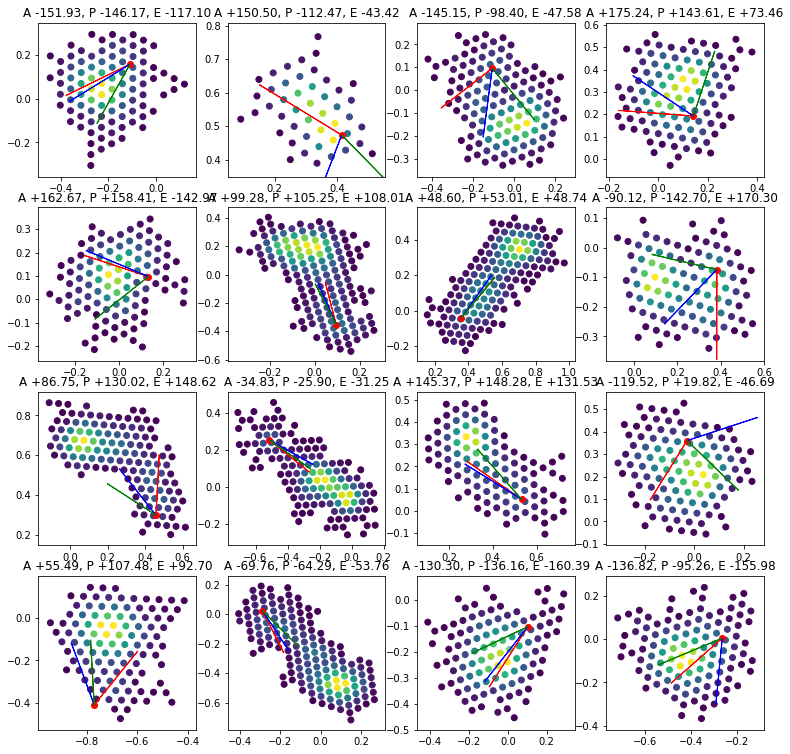

In [10]:
### plot results on hex grid to show absorption points
print('Total MSE = ', test_mse)
print('Ellipsoidal MSE = ', ellipse_mse)
batch_size = 64
losstype = 'cos'
vlength = 0.3

for batch_idx, (X_batch, y_batch) in enumerate(test_loader):
    if (losstype == 'cos'):
        y_batch = np.arctan2(y_batch[:,1], y_batch[:,0])
        
    if batch_idx == 1:
        plt.figure(figsize=(13,13))
        for idx in range(1,17):
            plt.subplot(4,4,idx)
            plt.scatter(datahex[batch_idx*batch_size+idx].x,datahex[batch_idx*batch_size+idx].y,c=datahex[batch_idx*batch_size+idx].Q) 
            plt.scatter(datahex[batch_idx*batch_size+idx].absorption_point[0],datahex[batch_idx*batch_size+idx].absorption_point[1],c='r')
            plt.arrow(datahex[batch_idx*batch_size+idx].absorption_point[0],datahex[batch_idx*batch_size+idx].absorption_point[1], vlength * np.cos(y_batch[idx]), vlength * np.sin(y_batch[idx]),color='r')
            plt.arrow(datahex[batch_idx*batch_size+idx].absorption_point[0],datahex[batch_idx*batch_size+idx].absorption_point[1], vlength * np.cos(test_metrics['y_hat_angles'][batch_idx*batch_size+idx]), vlength * np.sin(test_metrics['y_hat_angles'][batch_idx*batch_size+idx]),color='b')
            plt.arrow(datahex[batch_idx*batch_size+idx].absorption_point[0],datahex[batch_idx*batch_size+idx].absorption_point[1], vlength * np.cos(ellipse_y_hats[batch_idx*batch_size+idx]), vlength * np.sin(ellipse_y_hats[batch_idx*batch_size+idx]),color='g')
            
            plt.title("A {:+.2f}, P {:+.2f}, E {:+.2f}".format(180 * y_batch[idx] / np.pi,  180 * test_metrics['y_hat_angles'][batch_idx*batch_size+idx] / np.pi ,180 * ellipse_y_hats[batch_idx*batch_size+idx] / np.pi))
        break

In [23]:
l = np.array([])
for i in range(5000):
    l = np.append(l,datahex[i].x)
print(np.mean(l), np.std(l))
print(np.max(l), np.min(l))

0.002101349029718212 0.4177102249161719
4.131865501403809 -5.97442626953125


## Angular Distributions for Sim Data

Kevin's best network predicted angle distribution for unpolarized 6p4 simulated data:

Text(0.5,1,'Best Net')

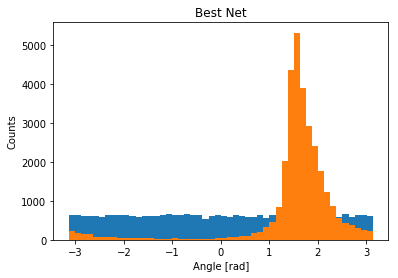

In [13]:
with h5py.File(data_file, 'r') as f:
    test_angles = f['test']['angles'][()]

test_angles = [test_angle + 2*np.pi if test_angle < -np.pi else test_angle for test_angle in test_angles]
ax = plt.hist(test_angles,50)
ax = plt.hist(test_metrics['y_hat_angles'],50)
plt.xlabel('Angle [rad]')
plt.ylabel('Counts')
plt.title('Best Net')

Ellipsoidal Moment method predicted angle distribution for unpolarized 6p4 simulated data:

Text(0.5,1,'Ellipsoidal')

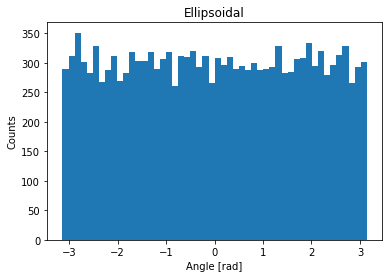

In [26]:
ax = plt.hist(ellipse_y_hats,50)
plt.xlabel('Angle [rad]')
plt.ylabel('Counts')
plt.title('Ellipsoidal')

Actual simulated data angular distribution:

Text(0.5,1,'Actual')

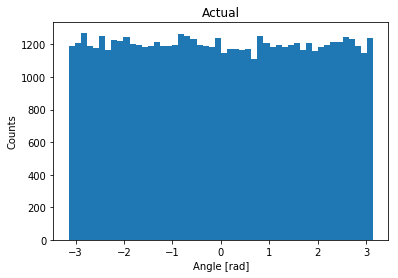

In [3]:
ax = plt.hist(datahex_file['test']['angles'][()],50)
plt.xlabel('Angle [rad]')
plt.ylabel('Counts')
plt.title('Actual')

## Now test on real data

Measured Data is unpolarized here throughout

In [16]:
#6p4 real tracks visualize + predict polarization
data_file = home_dir + 'data/expanded/set1_6p4_meas_dense_square_tracks_0pol_67190tot.h5'
test = H5Dataset(data_file,'train', datatype='meas', losstype='cos',transform=transforms.Compose([ZNormalize(mean=train.tracks_mean,std=train.tracks_std,set_max=train.tracks_max), ToTensor()]))
kwargs = {'num_workers': 1, 'pin_memory': True}
test_loader = torch.utils.data.DataLoader(test, batch_size=64, shuffle=False, **kwargs)

net = recursively_load_dict_contents_from_group(h5py.File(home_dir + 'data/nn/gen2a_test_1cos/models/net1_0.h5', 'r')) #desired net to visualize
#net = recursively_load_dict_contents_from_group(h5py.File(home_dir + 'data/nn/set1_test_3/models/net6_0.h5', 'r')) #desired net to visualize
net['hparams']['outputtype'] = net['hparams']['outputtype'].decode("utf-8") #strings saved as byte strings originally
net['opts']['losstype'] = net['opts']['losstype'].decode("utf-8")
net['hparams']['pool1pixels'] = int(net['hparams']['pool1pixels']) #MaxPool2D function doesnt like np.int
net['hparams']['pool3pixels'] = int(net['hparams']['pool3pixels'])

m = TrackAngleRegressor(model=net)


In [17]:
y_hat_angles = m.predict(test_loader)

Evaluating on GPU 



In [18]:
#Use ellipse based methods to calculate angles 
datahex_file = h5py.File(home_dir + 'data/expanded/' + 'set1_6p4_meas_sparse_hex_tracks_0pol_67190tot.h5', 'r')
datahex = SparseHexTracks.load(f=datahex_file['train'])

In [19]:
ellipse_y_hats = []
for i in range(datahex.n_tracks):
    theta,_,_ = calc_angle(datahex[i])
    ellipse_y_hats.append(theta)
ellipse_y_hats = np.array(ellipse_y_hats)

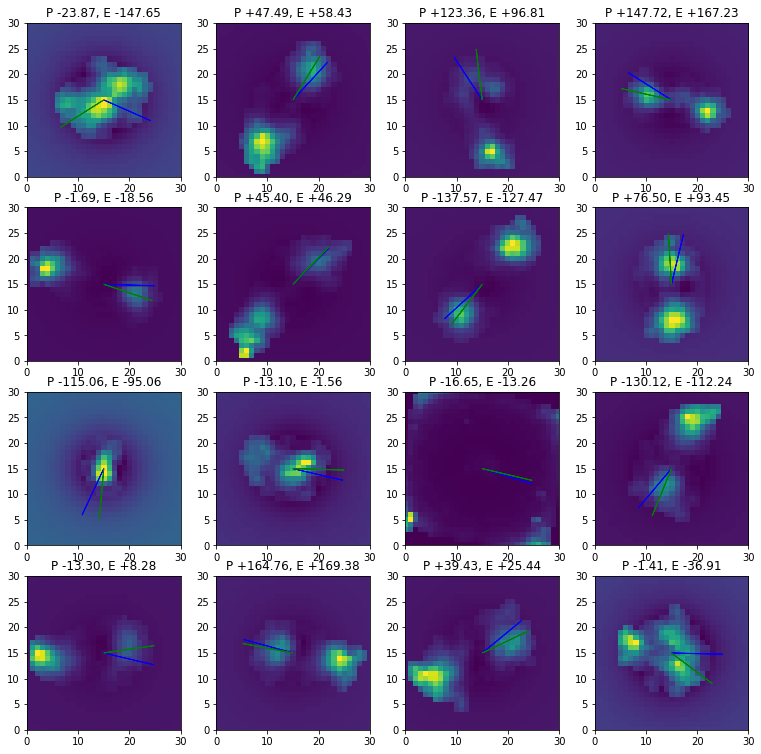

In [20]:
### plot results
batch_size = 64
losstype = 'cos'
vlength = 10

for batch_idx, (X_batch, y_batch) in enumerate(test_loader):
    if (losstype == 'cos'):
        y_batch = np.arctan2(y_batch[:,1], y_batch[:,0])
        
    if batch_idx == 7:
        plt.figure(figsize=(13,13))
        for idx in range(1,17):
            plt.subplot(4,4,idx)
            plt.imshow(X_batch[idx,0])     
            #plt.plot([0,15.5,30],[15.5+15.5*np.tan(y_batch[idx]),15.5,-30*np.tan(y_batch[idx]) + 15.5+15.5*np.tan(y_batch[idx])],'r--')
            #plt.plot([0,15.5,30],[15.5+15.5*np.tan(test_metrics['y_hat_angles'][batch_idx*batch_size+idx]),15.5,-30*np.tan(test_metrics['y_hat_angles'][batch_idx*batch_size+idx]) + 15.5+15.5*np.tan(test_metrics['y_hat_angles'][batch_idx*batch_size+idx])],'b--')
            #plt.plot([0,15.5,30],[15.5+15.5*np.tan(ellipse_y_hats[batch_idx*batch_size+idx]),15.5,-30*np.tan(ellipse_y_hats[batch_idx*batch_size+idx]) + 15.5+15.5*np.tan(ellipse_y_hats[batch_idx*batch_size+idx])],'g--')
            #plt.arrow(15,15, vlength * np.cos(y_batch[idx]), vlength * np.sin(y_batch[idx]),color='r')
            plt.arrow(15,15, vlength * np.cos(y_hat_angles[batch_idx*batch_size+idx]), vlength * np.sin(y_hat_angles[batch_idx*batch_size+idx]),color='b')
            plt.arrow(15,15, vlength * np.cos(ellipse_y_hats[batch_idx*batch_size+idx]), vlength * np.sin(ellipse_y_hats[batch_idx*batch_size+idx]),color='g')
            
            plt.xlim(0,30)
            plt.ylim(0,30)
            
            plt.title("P {:+.2f}, E {:+.2f}".format(180 * y_hat_angles[batch_idx*batch_size+idx] / np.pi ,180 * ellipse_y_hats[batch_idx*batch_size+idx] / np.pi))
        break

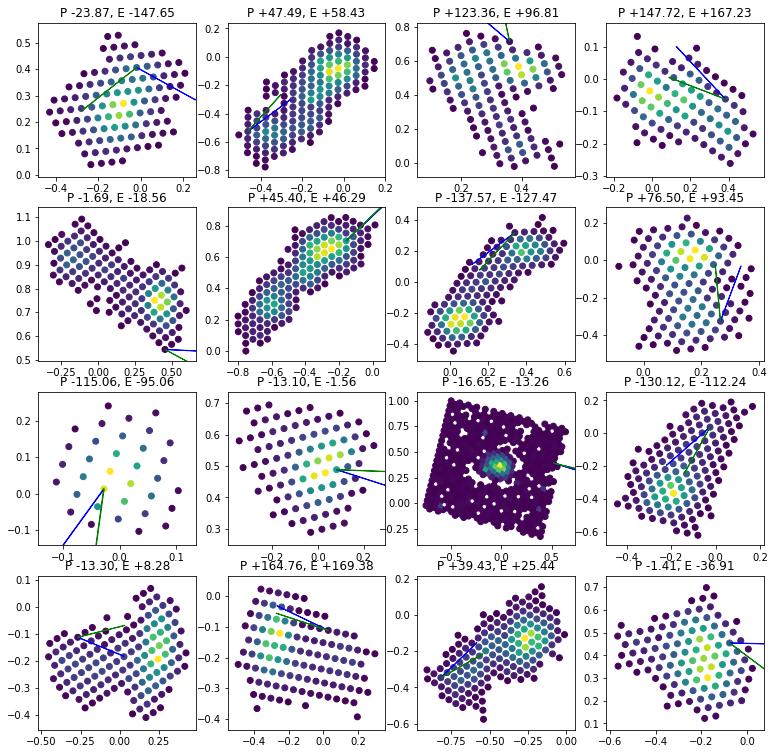

In [22]:
#Dont have Absorption Points this time as the data is measured, so plot arrows on an aribitrary point
batch_size = 64
losstype = 'cos'
vlength = 0.3

for batch_idx, (X_batch, y_batch) in enumerate(test_loader):
    if (losstype == 'cos'):
        y_batch = np.arctan2(y_batch[:,1], y_batch[:,0])
        
    if batch_idx == 7:
        plt.figure(figsize=(13,13))
        for idx in range(1,17):
            plt.subplot(4,4,idx)
            plt.scatter(datahex[batch_idx*batch_size+idx].x,datahex[batch_idx*batch_size+idx].y,c=datahex[batch_idx*batch_size+idx].Q) 
            #plt.scatter(datahex[batch_idx*batch_size+idx].absorption_point[0],datahex[batch_idx*batch_size+idx].absorption_point[1],c='r')
            #plt.arrow(datahex[batch_idx*batch_size+idx].absorption_point[0],datahex[batch_idx*batch_size+idx].absorption_point[1], vlength * np.cos(y_batch[idx]), vlength * np.sin(y_batch[idx]),color='r')
            plt.arrow(datahex[batch_idx*batch_size+idx].x[20],datahex[batch_idx*batch_size+idx].y[20], vlength * np.cos(y_hat_angles[batch_idx*batch_size+idx]), vlength * np.sin(y_hat_angles[batch_idx*batch_size+idx]),color='b')
            plt.arrow(datahex[batch_idx*batch_size+idx].x[20],datahex[batch_idx*batch_size+idx].y[20], vlength * np.cos(ellipse_y_hats[batch_idx*batch_size+idx]), vlength * np.sin(ellipse_y_hats[batch_idx*batch_size+idx]),color='g')
            
            plt.title("P {:+.2f}, E {:+.2f}".format(180 * y_hat_angles[batch_idx*batch_size+idx] / np.pi ,180 * ellipse_y_hats[batch_idx*batch_size+idx] / np.pi))
        break

## Angular Distributions and Modulation Factors

Kevins best net predicts a considerable polarization fraction when there is none (Measured data is unpolarized). Very strange bias, since Ellipsoidal methods doesn't display this behavior and it looks at the hex track (not square), it is likely that the problem arises from the hex -> square transformation. The shape of the distribution shown below is similar to the one for unpolarized sim data above => a systematic problem, also perhaps from training data generation.

phi0: -1.5060, mu: 0.3691


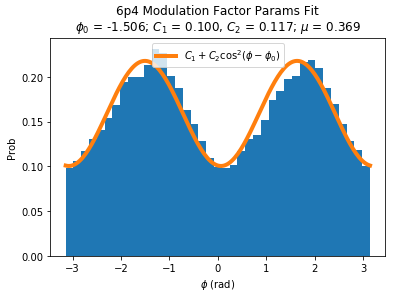

In [13]:
# Get polarization angle
#   Can use x,y to plot
y_hat_angles = measured_finaltest
#y_hat_angles = ellipse_y_hats 

phi0, x, y = fit_polarization_angle(y_hat_angles, method='mse', output_errors=True, use_parallel=True,
                                                use_grid_search=True, use_gradient=True, verbose=False)
# Get modulation factor
C1, C2 = fit_modulation_factor_params(y_hat_angles, phi0)
mu = modulation_factor(C1, C2)

# Show result numbers
print('phi0: {:.4f}, mu: {:.4f}'.format(phi0, mu))

# Plot just the prediction hists
#plot_angle_preds_only(y_hat_angles, '6p4')

# Plot with fits
plot_angle_preds(y_hat_angles, phi0, C1, C2, mu, '6p4')

#ax = plt.hist(y_hat_angles,100)
#plt.ylim(0,2000)

Text(0.5,1,'Best Net')

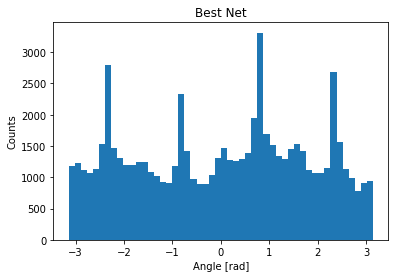

In [27]:
ax = plt.hist(y_hat_angles,50)
plt.xlabel('Angle [rad]')
plt.ylabel('Counts')
plt.title('Best Net')

Ellipsoidal Method predicts an unpolarized ensemble as expected:

In [25]:
#for ellipse method
# Get polarization angle
#   Can use x,y to plot
phi0, x, y = fit_polarization_angle(ellipse_y_hats, method='mse', output_errors=True, use_parallel=True,
                                                use_grid_search=True, use_gradient=True, verbose=False)
# Get modulation factor
C1, C2 = fit_modulation_factor_params(ellipse_y_hats, phi0)
mu = modulation_factor(C1, C2)

# Show result numbers
print('phi0: {:.4f}, mu: {:.4f}'.format(phi0, mu))

# Plot just the prediction hists
#plot_angle_preds_only(y_hat_angles, '6p4')

# Plot with fits
plot_angle_preds(ellipse_y_hats, phi0, C1, C2, mu, '6p4')

KeyboardInterrupt: 

## TEST Hexagdly

In [2]:
fhex = h5py.File(home_dir + 'data/expanded/set1_6p4_sim_sparse_hex_tracks_0pol_15000tot.h5', 'r')

(-0.2, 0.8)

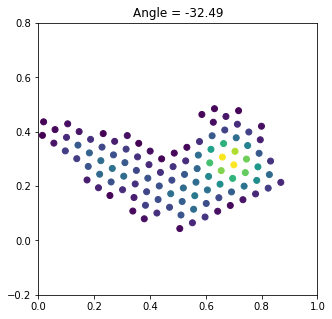

In [3]:
x = fhex['train']['x'][4] 
y= fhex['train']['y'][4]
q = fhex['train']['Q'][4]
angle = 180 * fhex['train']['angles'][4] /np.pi
plt.figure(figsize=(5,5))
plt.scatter(x,y,c=q)
plt.title("Angle = {:+.2f}".format(180 * fhex['train']['angles'][4] / np.pi))
plt.xlim([0.0,1.0])
plt.ylim([-0.2,0.8])

r,a 0.02499929790692059 0.0288667027522245


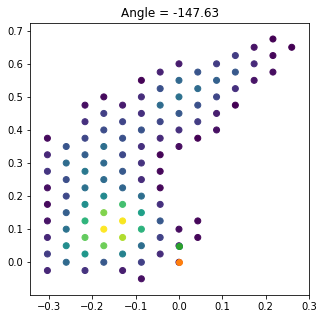

In [4]:
#Rotate coordinate system
#need to know coordinate system angle and distance between points r
y = y[np.isfinite(y)]
x = x[np.isfinite(x)]
q = q[q != -1]

adj = np.argmin(np.sqrt((x - x[0])**2 +  (y - y[0])**2)[1:]) + 1 #find adjacent point
r = np.sqrt((x[0]-x[adj])**2 + (y[0]-y[adj])**2) / 2
#r = 0.025
a = r / np.cos(30*np.pi/180)
print('r,a', r,a)

q_norm = q / np.sum(q) #q has -1 in empty slots
x_ws = x[0] #np.nansum(x * q_norm)  # weighted sum
y_ws = y[0] #np.nansum(y * q_norm)

x,y = x-x_ws, y-y_ws
radius = np.sqrt(x**2 + y**2)
theta = np.arctan2(y,x)
rotation = np.arccos((y[adj]) / (np.sqrt((y[adj])**2 + (x[adj])**2)))
if (x[adj] < 0):
    rotation = -rotation
x,y = radius*np.cos(theta+rotation), radius*np.sin(theta+rotation)
angle += rotation * 180/np.pi 

plt.figure(figsize=(5,5))
plt.title("Angle = {:+.2f}".format(angle))
plt.scatter(x,y,c=q)
plt.scatter(x[adj],y[adj])
plt.scatter(x[0],y[0])
plt.scatter(x[3],y[3])
#plt.scatter(0,0)
#plt.scatter(x_ws,y_ws)

0.2598057


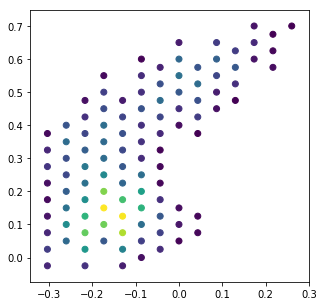

In [12]:
y = np.where(np.mod(np.round((x-x.min())/(1.5*a)),2)==1, y+r, y)
plt.figure(figsize=(5,5))
plt.scatter(x,y,c=q)
print(max(x))

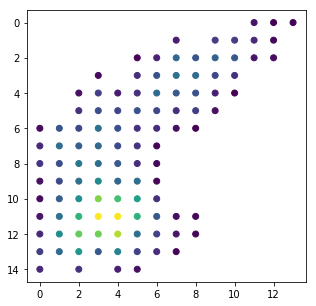

In [6]:
i,j = np.round((x-x.min()) / (1.5*a)), np.round((-1*(y-y.max())) / (2*r))
plt.figure('indexed',figsize=(5,5))
ax = plt.gca()
plt.scatter(i,j,c=q)
ax.invert_yaxis()

In [178]:
q

array([ 11,  15,  12,  17,  25,  32,  20,  12,  14,  33,  52,  62,  42,
        27,  42,  85, 113, 101,  72,  50,  23,  26,  76, 126, 127,  99,
        67,  31,  12,  52,  92, 105,  86,  54,  23,  12,  25,  48,  65,
        68,  45,  16,  15,  10,  14,  11,  27,  42,  51,  53,  36,  13,
        10,  20,  31,  26,  24,  26,  36,  50,  57,  38,  15,  14,  16,
        26,  35,  39,  42,  35,  40,  39,  52,  45,  51,  28,  10,  12,
        24,  42,  46,  51,  53,  51,  26,  34,  37,  35,  41,  23,  10,
        16,  31,  31,  41,  49,  39,  25,  19,  32,  26,  13,  19,  21,
        11,  13,  15], dtype=int16)

In [10]:
final = np.zeros((16,18))
final[i.astype(np.int),j.astype(np.int)] = q

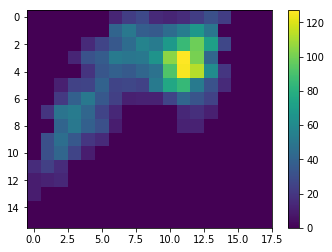

In [11]:
plt.imshow(final)  
plt.colorbar()

In [11]:
def hex2square(x,y,q,angle):
    y = y[np.isfinite(y)]
    x = x[np.isfinite(x)]
    q = q[q != -1]
    
    adj = np.argmin(np.sqrt((x - x[0])**2 +  (y - y[0])**2)[1:]) + 1 #find adjacent point
    r = np.sqrt((x[0]-x[adj])**2 + (y[0]-y[adj])**2) / 2
    a = r / np.cos(30*np.pi/180)
    
    x_ws = x[0] #np.nansum(x * q_norm)  # weighted sum
    y_ws = y[0] #np.nansum(y * q_norm)
    
    x,y = x-x_ws, y-y_ws
    radius = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y,x)
    rotation = np.arccos((y[adj]) / (np.sqrt((y[adj])**2 + (x[adj])**2)))
    if (x[adj] < 0):
        rotation = -rotation
    x,y = radius*np.cos(theta+rotation), radius*np.sin(theta+rotation)
    angle_new = angle + rotation * 180/np.pi 
    if angle_new > 180:
        angle_new -= 360
    elif angle_new < -180:
        angle_new += 360
    
    y = np.where(np.mod(np.round((x-x.min())/(1.5*a)),2)==1, y+r, y)
    i,j = np.round((x-x.min()) / (1.5*a)), np.round((-1*(y-y.max())) / (2*r))
    maxi = np.max(i)
    maxj = np.max(j)

    square = np.zeros((28,28))
    square[j.astype(np.int),i.astype(np.int)] = q
    
    return square, angle_new, maxi, maxj #square array
    

In [12]:
Is = []
Js = []
sqs = []
angs = []
for k in range(15000):
    x = fhex['train']['x'][k] 
    y= fhex['train']['y'][k]
    q = fhex['train']['Q'][k]
    angle = 180 * fhex['train']['angles'][k] /np.pi
    sq, angle_new, maxi, maxj = hex2square(x,y,q,angle)
    Is.append(maxi)
    Js.append(maxj)
    sqs.append(sq)
    angs.append(angle_new)
    

27.0 23.0


(array([447., 445., 363., 402., 370., 329., 301., 236., 252., 185., 165.,
        147., 171., 158., 171., 173., 182., 241., 301., 294., 371., 404.,
        411., 438., 466., 472., 465., 443., 423., 354., 367., 292., 234.,
        251., 204., 165., 158., 172., 181., 177., 195., 212., 234., 281.,
        326., 369., 363., 395., 407., 437.]),
 array([-1.79991271e+02, -1.72791514e+02, -1.65591757e+02, -1.58392000e+02,
        -1.51192243e+02, -1.43992485e+02, -1.36792728e+02, -1.29592971e+02,
        -1.22393214e+02, -1.15193457e+02, -1.07993700e+02, -1.00793943e+02,
        -9.35941857e+01, -8.63944286e+01, -7.91946715e+01, -7.19949144e+01,
        -6.47951573e+01, -5.75954002e+01, -5.03956431e+01, -4.31958860e+01,
        -3.59961289e+01, -2.87963718e+01, -2.15966147e+01, -1.43968576e+01,
        -7.19710045e+00,  2.65666073e-03,  7.20241377e+00,  1.44021709e+01,
         2.16019280e+01,  2.88016851e+01,  3.60014422e+01,  4.32011993e+01,
         5.04009564e+01,  5.76007135e+01,  6.48004

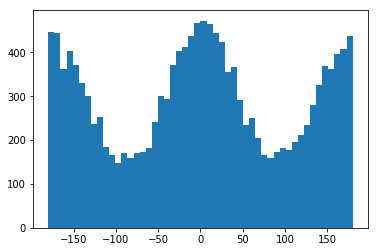

In [13]:
print(max(Is),max(Js))
plt.hist(angs,50)

In [215]:
np.nanmax(sqs_)

31.60696125855813

/home/users/alpv95/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/home/users/alpv95/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
/home/users/alpv95/.local/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


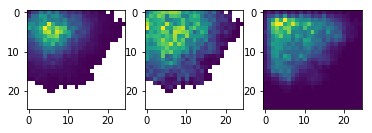

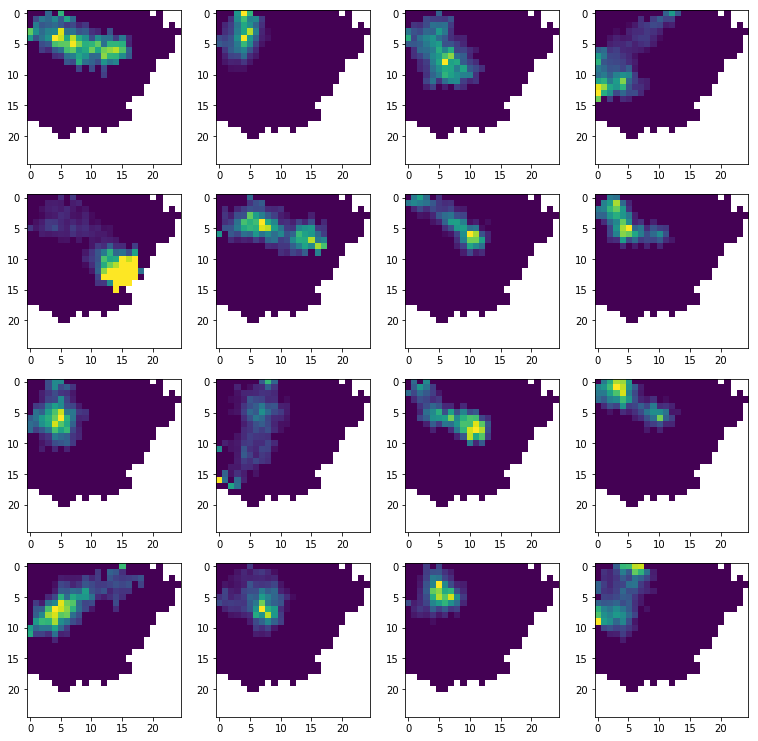

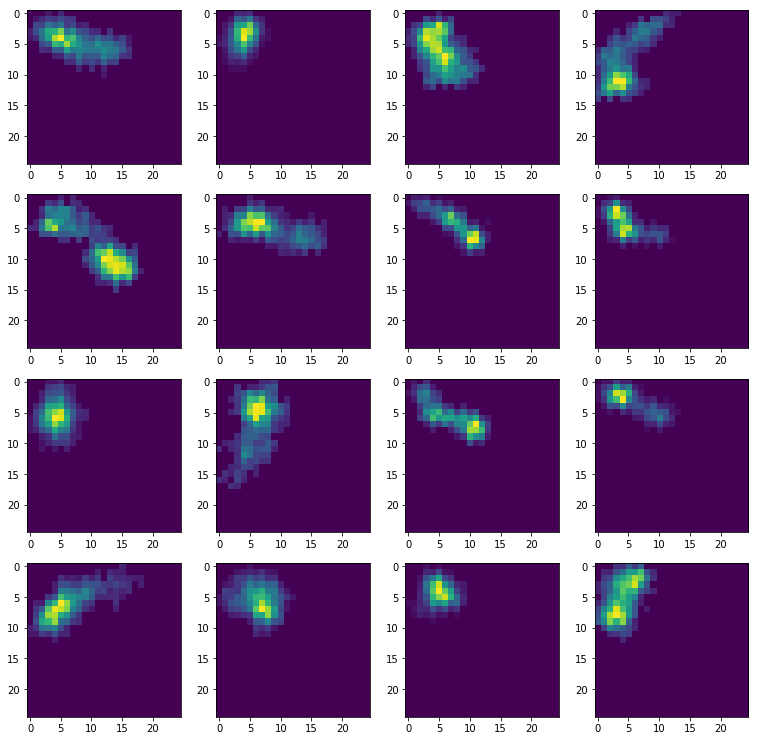

In [216]:
sqs_ = np.array(sqs)
maxx = np.max(sqs_, axis=0) 
mean = np.mean(sqs_/maxx , axis=0)
std = np.std(sqs_/maxx , axis=0)
plt.figure(1)
plt.subplot(1,3,1)
plt.imshow(mean)
plt.subplot(1,3,2)
plt.imshow(std)
plt.subplot(1,3,3)
plt.imshow(maxx)

#sqs_ = np.divide((sqs_/maxx - mean), std, out=np.zeros_like(sqs_), where=std!=0) 
sqs_ = sqs_ / maxx
plt.figure(figsize=(13,13))
for idx in range(1,17):
    plt.subplot(4,4,idx)
    plt.imshow(sqs_[idx])

plt.figure(figsize=(13,13))
for idx in range(1,17):
    plt.subplot(4,4,idx)
    plt.imshow(sqs[idx])

In [34]:
conv1 = hexagdly.Conv2d(in_channels = 1, out_channels = 4, kernel_size = 2, stride = 1, bias=True)
pool1 = hexagdly.MaxPool2d(kernel_size = 1, stride = 2)

In [35]:
x = torch.rand(4,1,21,21)

In [36]:
pool1(conv1(x)).shape

torch.Size([4, 4, 10, 11])

In [1]:
############  TEST  ZONE  ##############

In [8]:
from collections import namedtuple
from formats.sparse_hex import SparseHexTracks, SparseHexSimTracks

input_base = 'data/cleaned/'
Dataset = namedtuple('Dataset', ['name', 'energy', 'pol', 'type'])
datasets = [Dataset('set2', 2.0, 'pol', 'sim'),]
keep_str = ''

In [13]:
for dataset in datasets:
        print('Building dataset for {name} {energy} keV {type}'.format(**dataset._asdict()))

        energy_str = '{:.1f}'.format(dataset.energy).replace('.', 'p')
        input_file = os.path.join(home_dir + input_base, '{}_{}_{}_{}_sparse_hex_tracks_cleaned{}.h5'.format(
            dataset.name, energy_str, dataset.pol, dataset.type, keep_str
        ))

        if dataset.type == 'sim':
            hex_tracks = SparseHexSimTracks.load(input_file)
        else:
            hex_tracks = SparseHexTracks.load(input_file)

Building dataset for set2 2.0 keV sim


In [15]:
hex_tracks.n_tracks

100323

## Mean and STD tracks images

In [12]:
f = h5py.File(home_dir + 'data/expanded/set2_2p0_sim_dense_square_tracks_0pol_70000tot.h5', 'r')

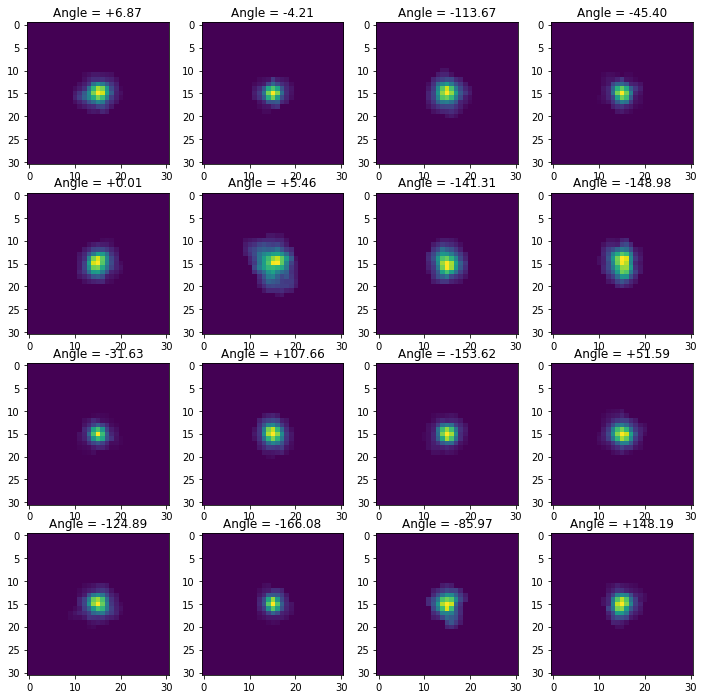

In [37]:
#individual electron tracks
plt.figure(figsize=(12,12))
for idx in range(1,17):
    plt.subplot(4,4,idx)
    plt.imshow(f['train']['tracks_cube'][idx])
    plt.title("Angle = {:+.2f}".format(180 * f['train']['angles'][idx] / np.pi))

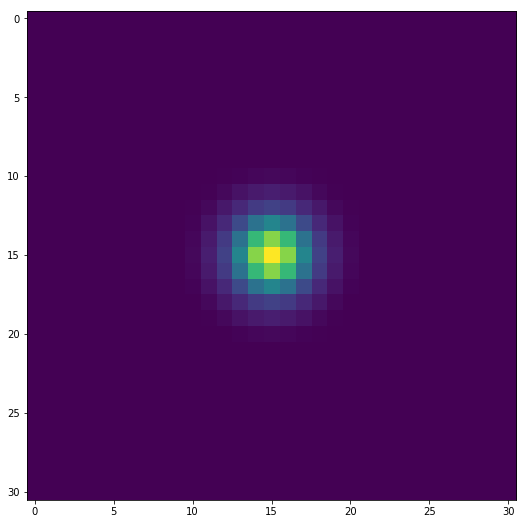

In [42]:
# electron track mean
plt.figure(figsize=(9,9))
maxx = np.max(f['train']['tracks_mean'][...])
plt.imshow(f['train']['tracks_mean'][...] / maxx)

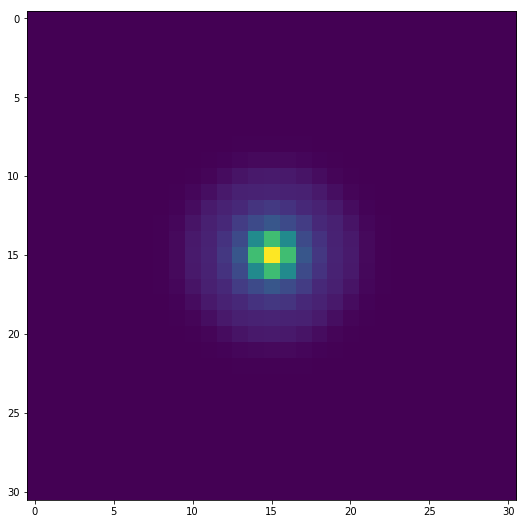

In [43]:
# electron track std
plt.figure(figsize=(9,9))
maxx = np.max(f['train']['tracks_std'][...])
plt.imshow(f['train']['tracks_std'][...] / maxx)

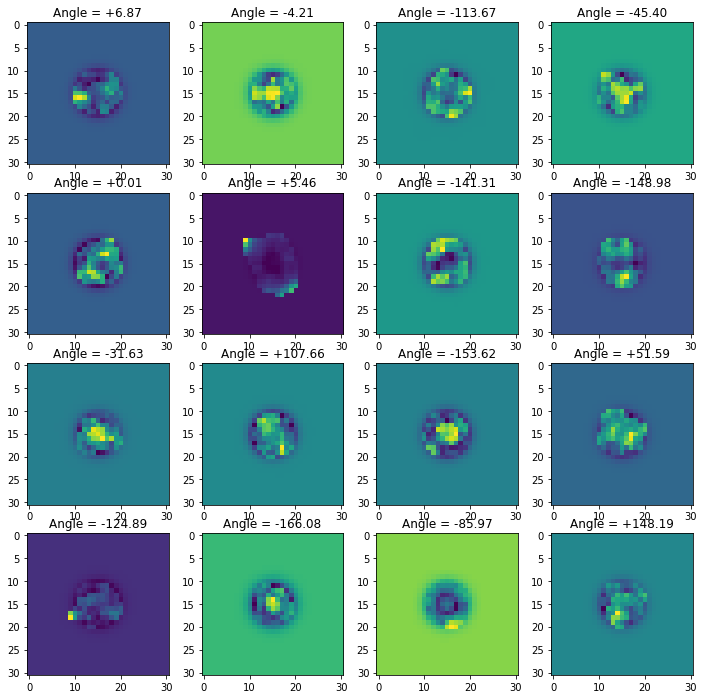

In [27]:
# individual electron tracks with normalization applied, should try different normalizations, like no std or total pixel mean subtraction
maxx = np.max(f['train']['tracks_cube'][...])
std = f['train']['tracks_std'][...]
mean = f['train']['tracks_mean'][...]

plt.figure(figsize=(12,12))
for idx in range(1,17):
    plt.subplot(4,4,idx)
    mean_centered = f['train']['tracks_cube'][idx] / maxx - mean
    normalized = np.divide(mean_centered, std, out=np.zeros_like(mean_centered), where=std!=0)
    plt.imshow(normalized)
    plt.title("Angle = {:+.2f}".format(180 * f['train']['angles'][idx] / np.pi))

In [ ]:
#Now need to visualize measured data + sparse hex representation to compare

In [4]:
f = h5py.File(home_dir + 'data/expanded/set2_2p0_sim_sparse_hex_tracks_0pol_70000tot.h5', 'r')

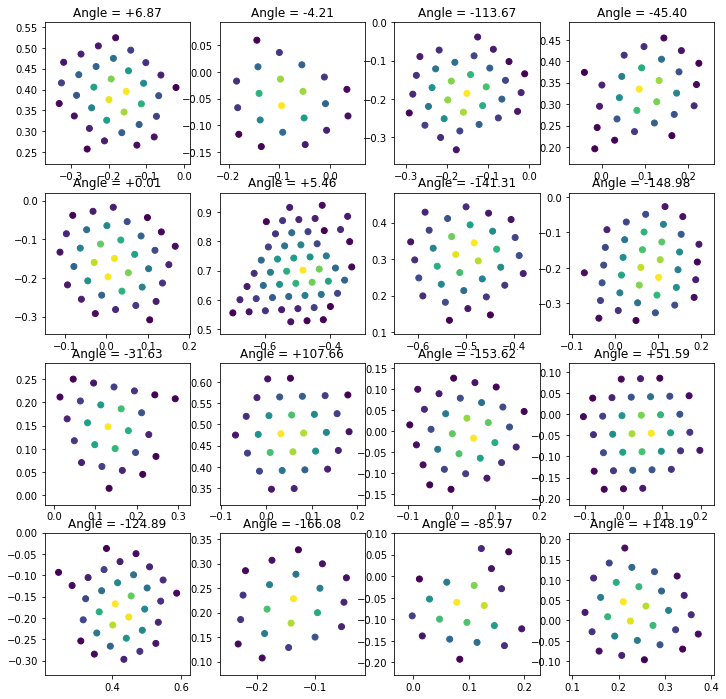

In [16]:
plt.figure(figsize=(12,12))
for idx in range(1,17):
    plt.subplot(4,4,idx)
    plt.scatter(f['train']['x'][idx],f['train']['y'][idx],c=f['train']['Q'][idx])
    plt.scatter(f['train']['absorption_points'][idx][0],f['train']['absorption_points'][idx][1],c='r')
    plt.title("Angle = {:+.2f}".format(180 * f['train']['angles'][idx] / np.pi))


In [45]:
f['train'].keys()

<KeysViewHDF5 ['Q', 'absorption_points', 'angles', 'n_pixels', 'n_tracks', 'x', 'y']>

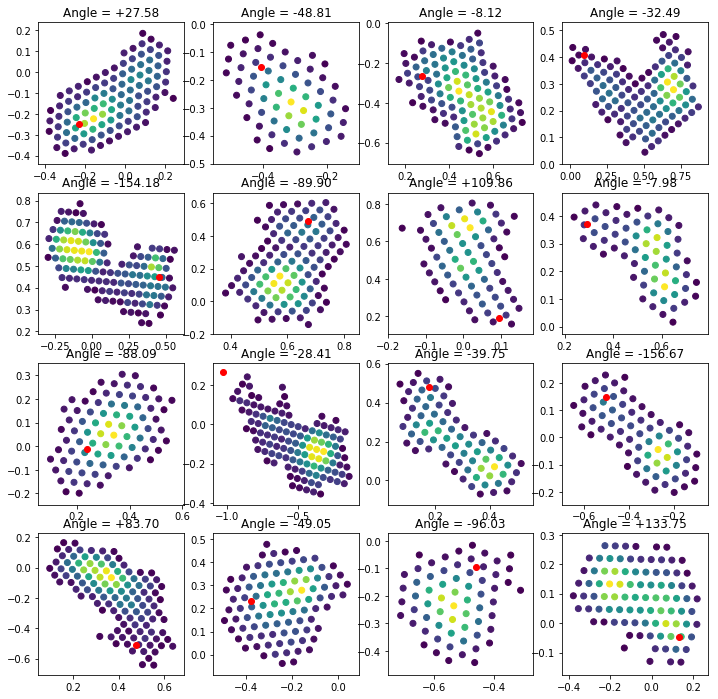

In [46]:
f = h5py.File(home_dir + 'data/expanded/set1_6p4_sim_sparse_hex_tracks_0pol_15000tot.h5', 'r')
plt.figure(figsize=(12,12))
for idx in range(1,17):
    plt.subplot(4,4,idx)
    plt.scatter(f['train']['x'][idx],f['train']['y'][idx],c=f['train']['Q'][idx])
    plt.scatter(f['train']['absorption_points'][idx][0],f['train']['absorption_points'][idx][1],c='r')
    plt.title("Angle = {:+.2f}".format(180 * f['train']['angles'][idx] / np.pi))
    

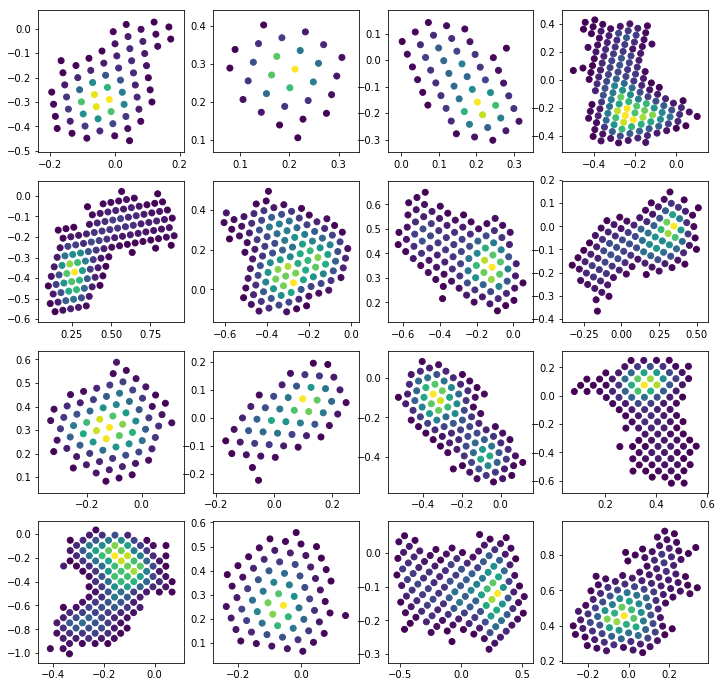

In [21]:
f = h5py.File(home_dir + 'data/expanded/set1_6p4_meas_sparse_hex_tracks_0pol_67190tot.h5', 'r')
plt.figure(figsize=(12,12))
for idx in range(1,17):
    plt.subplot(4,4,idx)
    plt.scatter(f['train']['x'][idx],f['train']['y'][idx],c=f['train']['Q'][idx])

In [3]:
#Why is pydataloader so slow?:
from util.pydataloader import H5Dataset, ZNormalize, ToTensor
from formats.dense_square import DenseSquareSimTracks
from torchvision import transforms, datasets

In [4]:
with h5py.File(home_dir + 'data/expanded/set2_2p0_sim_dense_square_tracks_0pol_70000tot.h5', 'r') as f:
        train = DenseSquareSimTracks.load(f=f['train'])

In [9]:
train = H5Dataset(home_dir + 'data/expanded/set2_2p0_sim_dense_square_tracks_0pol_70000tot.h5','train',transform=transforms.Compose([ZNormalize(train.tracks_mean,train.tracks_std,train.tracks_max),ToTensor()]))

In [12]:
#kwargs = {'num_workers': 1, 'pin_memory': True}
kwargs = {'num_workers': 1, 'pin_memory': True}
train_loader = torch.utils.data.DataLoader(train, batch_size=256, shuffle=True, **kwargs)


In [14]:
h5_path = home_dir + 'data/expanded/set1_6p4_sim_dense_square_tracks_0pol_50000tot.h5'
h5_file = h5py.File(h5_path)
data = h5_file.get('train/tracks_cube')
labels = h5_file.get('train/angles')

# _, pixels, _ = f['train']['tracks_cube'].shape
# max = f['train']['tracks_max']
# mean = f['train']['tracks_mean']
# std = f['train']['tracks_std']
# tracks_cube = f['train']['tracks_cube']
# angles = f['train']['angles']

In [18]:
h5_file.get('test/tracks_cube').shape

(1815, 31, 31)

In [13]:
x = data[()]
y = labels[()]

In [14]:
torch.save((x,y),'test.pt') #fast loading and saving with this (same as pickle but can also be used for torch tensors)

In [20]:
w,z = torch.load('test.pt')

In [21]:
w.shape

(70000, 31, 31)

In [13]:
for batch_idx, (Xbatch, ybatch) in enumerate(train_loader):
    print(batch_idx)
    #print(Xbatch[1])
    #plt.imshow(Xbatch[1][0])


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261


KeyboardInterrupt: 